# HomeWork 5 for GEOG 210A F25

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

from scipy.io import loadmat
import requests
from scipy.io import loadmat
from io import BytesIO

pd.options.display.float_format = '{:.2e}'.format

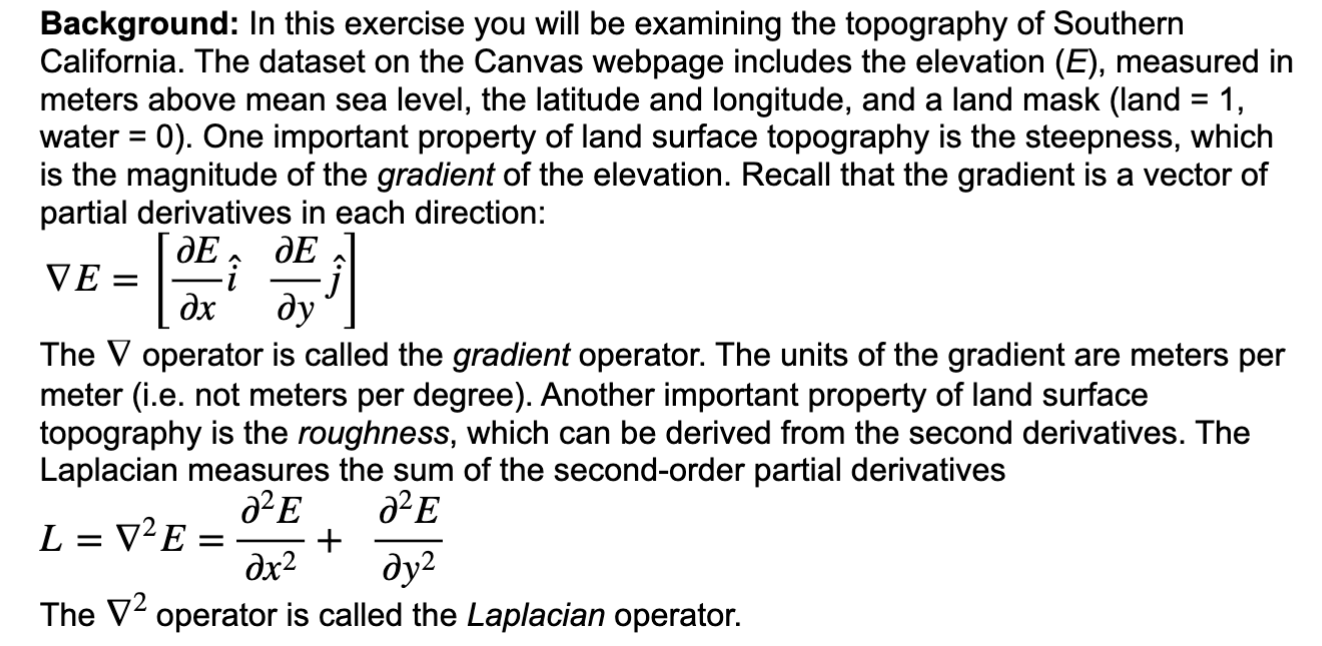

## Question 1: 
<font color="orange">
1. Load the dataset from Canvas into your Python workspace.
</font>

In [2]:
url = "https://ucsb.instructure.com/files/5755302/download?download_frd=1&verifier=5AZ7yh7HAh11WHTs3FEyzlNufxtRWEM9H6WKpGz6"
response = requests.get(url)
response.raise_for_status() # check for download errors
data = loadmat(BytesIO(response.content), simplify_cells=True)

elev = data['elevation']
lat = data['latitude']
lon = data['longitude']
mask = data['landmask']

## Question 2: 
<font color="orange">
Plot (Figure 1) the surface elevation using an appropriate visualization (e.g. contour or surface plot). Label the plot appropriately
</font>

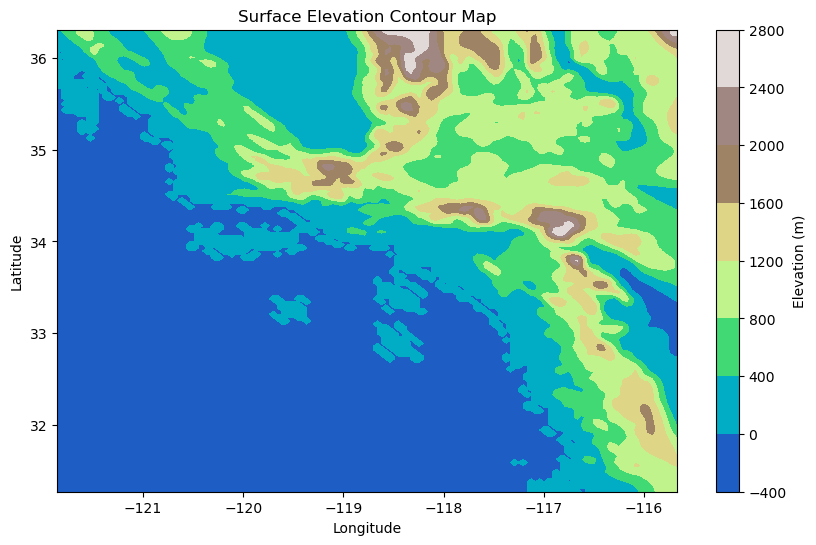

In [3]:
plt.figure(figsize=(10, 6))
plt.contourf(lon, lat, elev, cmap="terrain")
plt.colorbar(label="Elevation (m)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Surface Elevation Contour Map")
plt.show()

## Question 3: 
<font color="orange">
Compute the partial derivatives of elevation in the x- and y-directions,using units of <u>cm/m</u>.Remember to convert your derivatives of latitude and longitude to distance.

- a) Plot (Figure 2) the partial derivatives in the x- and y-directions in separate subplots.
</font>

I searched google and I found one degree of **latitude**: consistent, reliable, 111.32 km (or 69.16 miles), and one degree of **longitude**: 111.32 × cos(latitude), you can review details [here](https://medium.com/@altair0622/title-how-far-is-one-degree-really-the-hidden-geometry-behind-your-gps-coordinates-eae177cec56b)


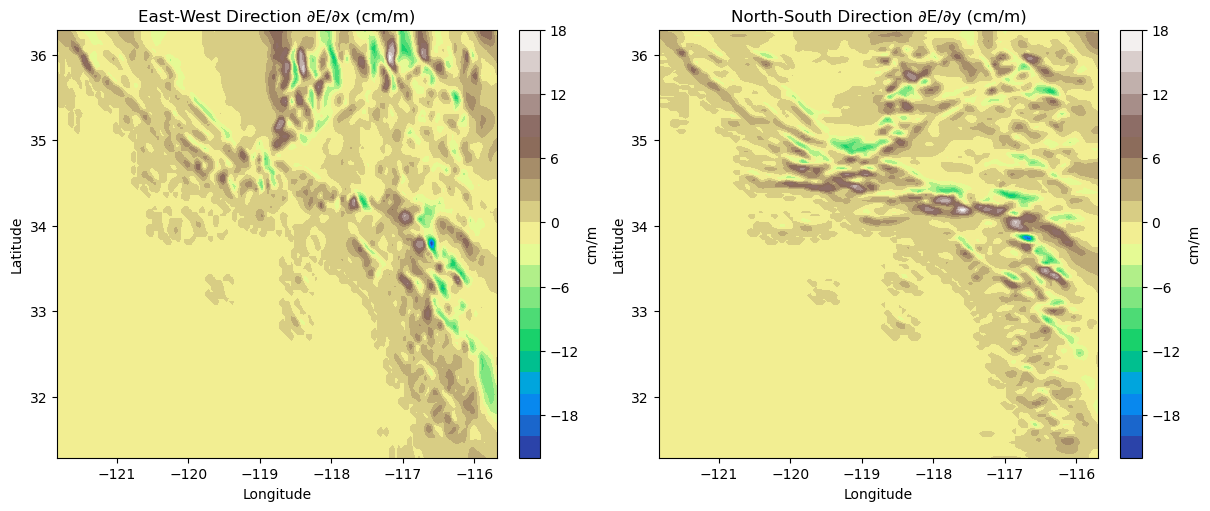

In [4]:
mean_lat = np.mean(lat) # I sue mean lat to present the average lat
dy = np.mean(np.diff(lat)) * 111320
dx = np.mean(np.diff(lon)) * 111320 * np.cos(np.deg2rad(mean_lat))

# dE_dx_edge present the deviation value in edge of grid
dE_dx_edge_m = (elev[:, 1:] - elev[:, :-1]) / dx   
dE_dy_edge_m = (elev[1:, :] - elev[:-1, :]) / dy   

# Move edge value to center point of grid
dE_dx_center_m = 0.5 * (dE_dx_edge_m[1:, :] + dE_dx_edge_m[:-1, :])
dE_dy_center_m = 0.5 * (dE_dy_edge_m[:, 1:] + dE_dy_edge_m[:, :-1])

# transfer m/m into cm/m
dE_dx_cm = dE_dx_center_m * 100
dE_dy_cm = dE_dy_center_m * 100

# move lon and lat into center point
lon_c = 0.5 * (lon[1:] + lon[:-1])    
lat_c = 0.5 * (lat[1:] + lat[:-1])    
Lon, Lat = np.meshgrid(lon_c, lat_c)

# plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
left = axes[0].contourf(Lon, Lat, dE_dx_cm, levels=21, cmap='terrain')  # ∂E/∂x
axes[0].set_title('East-West Direction ∂E/∂x (cm/m)')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
fig.colorbar(left, ax=axes[0], label='cm/m')
right = axes[1].contourf(Lon, Lat, dE_dy_cm, levels=21, cmap='terrain')  # ∂E/∂y
axes[1].set_title('North-South Direction ∂E/∂y (cm/m)')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
fig.colorbar(right, ax=axes[1], label='cm/m')

plt.show()

<font color="orange">
b) Is the land generally steeper in the east–west direction or north–south direction?
</font>

from threading above figure, we think the **north-south diection** is more generally steeper because north-south has more color contrast and more dense.

## Question 4: 
<font color="orange">
Compute and plot (Figure 3) the magnitude of the gradient vector (use the Pythagorean theorem). This is also called the steepness:

- a) In what mountain range are the steepest slopes in Southern California?
</font>

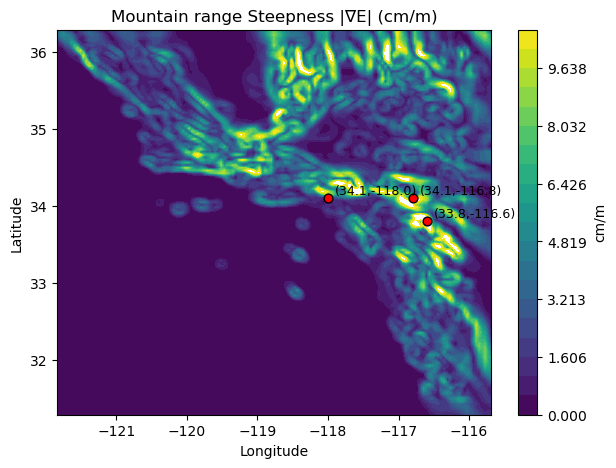

In [5]:
steep_mpm = np.sqrt(dE_dx_center_m**2 + dE_dy_center_m**2)   # m/m
steep_cpm = steep_mpm * 100.0                                # cm/m

vmax = np.nanpercentile(steep_cpm, 99) 
levels = np.linspace(0, vmax, 21)

plt.figure(figsize=(7,5))
cs = plt.contourf(Lon, Lat, steep_cpm, levels=levels, cmap='viridis')
plt.title('Mountain range Steepness |∇E| (cm/m)')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
cbar = plt.colorbar(cs, label='cm/m')

points = np.array([
    [34.1, -116.8],    
    [33.8, -116.6],    
    [34.1, -118]
])

plt.scatter(points[:,1], points[:,0], color='red', s=40, marker='o', edgecolor='black')
for (lat_p, lon_p) in points:
    plt.text(lon_p + 0.1, lat_p + 0.05, f'({lat_p},{lon_p})', color='black', fontsize=9)


plt.show()


From the figure, I highlight some red points to mark the steepest mountain in Southern California.

<font color="orange">
b) What region(s) is(are) the flattest in Southern California? (Not including the ocean).
</font>

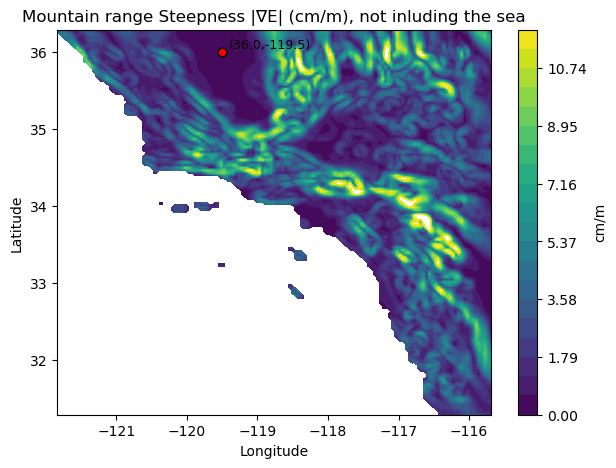

In [6]:
steep_mpm = np.sqrt(dE_dx_center_m**2 + dE_dy_center_m**2)   
steep_cpm = steep_mpm * 100.0                                

mask_center = 0.25*(mask[1:,1:] + mask[1:,:-1] + mask[:-1,1:] + mask[:-1,:-1])
steep_cpm[mask_center == 0] = np.nan

vmax = np.nanpercentile(steep_cpm, 99)  
levels = np.linspace(0, vmax, 21)

plt.figure(figsize=(7,5))
cs = plt.contourf(Lon, Lat, steep_cpm, levels=levels, cmap='viridis')
plt.title('Mountain range Steepness |∇E| (cm/m), not inluding the sea')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
cbar = plt.colorbar(cs, label='cm/m')

points = np.array([
    [36, -119.5],    
])
plt.scatter(points[:,1], points[:,0], color='red', s=40, marker='o', edgecolor='black')
for (lat_p, lon_p) in points:
    plt.text(lon_p + 0.1, lat_p + 0.05, f'({lat_p},{lon_p})', color='black', fontsize=9)

plt.show()


From the figure, I highlight one red point[36,-119.5] to mark the flattest in Southern California, not including the sea.

## Question 5: 
<font color="orange">
Compute the second-order partial derivatives and compute the Laplacian to measure the roughness of the topography.

- a) Plot (Figure 4) the Laplacian, using units of cm m⁻2 .
</font>

Based on second-order partial derivatives, 
$$
\frac{\partial^2 E}{\partial x^2} \approx 
\frac{E_{i,j+1} - 2E_{i,j} + E_{i,j-1}}{(\Delta x)^2},
\qquad
\frac{\partial^2 E}{\partial y^2} \approx 
\frac{E_{i+1,j} - 2E_{i,j} + E_{i-1,j}}{(\Delta y)^2}
$$


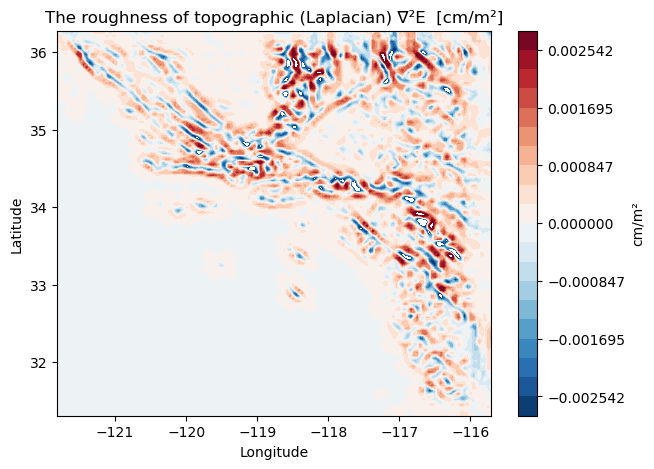

In [7]:
d2E_dx2 = (elev[1:-1, 2:] - 2*elev[1:-1, 1:-1] + elev[1:-1, :-2]) / (dx**2)
d2E_dy2 = (elev[2:, 1:-1] - 2*elev[1:-1, 1:-1] + elev[:-2, 1:-1]) / (dy**2)

L_mpm2 = d2E_dx2 + d2E_dy2
L_cpm2 = L_mpm2 * 100.0

lon_i = lon[1:-1]
lat_i = lat[1:-1]
Lon_i, Lat_i = np.meshgrid(lon_i, lat_i)

v = np.nanpercentile(np.abs(L_cpm2), 99) 
levels = np.linspace(-v, v, 21)

plt.figure(figsize=(7,5))
cs = plt.contourf(Lon_i, Lat_i, L_cpm2, levels=levels, cmap='RdBu_r')
plt.title('The roughness of topographic (Laplacian) ∇²E  [cm/m²]')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.colorbar(cs, label='cm/m²')
plt.show()

<font color="orange">
b) Where do you find the roughest topography in Southern California
</font>

You can find the red areas（concave-up）prensent mountain valley and the blue area(concave-down) repsent mountain range. Both of them are the roughest topography in southern california.

## Question 6: 
<font color="orange">
For geographic orientation, label the following cities/features on your plots.  

- a) Santa Barbara: (34.42, -119.70)  
- b) Los Angeles: (34.05, -118.25)
- c) Lancaster: (34.70, -118.15)
- d) San Luis Obispo: (35.28, -120.66)
- e) Bakersfield: (35.37, -119.02)
- f) San Diego: (32.72, -117.16)
- g) Palm Springs: (33.83, -116.54)
- h) Channel Islands: (33.99, -119.45)
- i) Salton Sea: (33.30, -115.82)
- j) San Joaquin valley: (36.0, -119.5)
- k) San Bernardino mountains: (34.25, -117.0)
- l) Santa Ynez mountains: (34.55, -120.1)
</font>

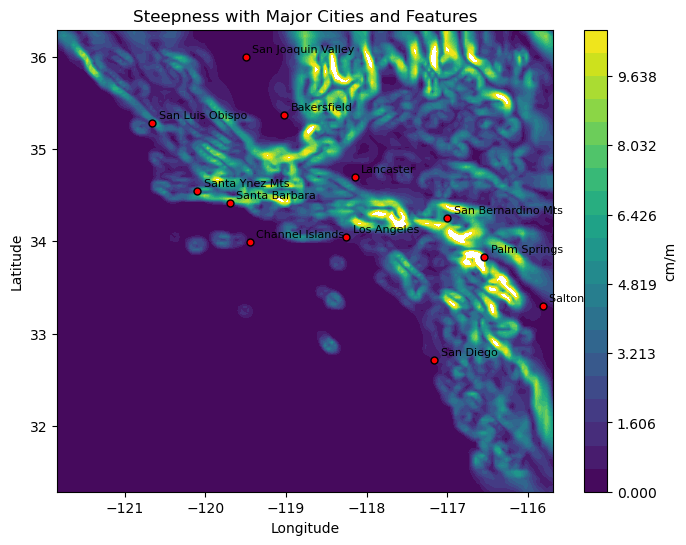

In [8]:
locations = {
    "Santa Barbara": (34.42, -119.70),
    "Los Angeles": (34.05, -118.25),
    "Lancaster": (34.70, -118.15),
    "San Luis Obispo": (35.28, -120.66),
    "Bakersfield": (35.37, -119.02),
    "San Diego": (32.72, -117.16),
    "Palm Springs": (33.83, -116.54),
    "Channel Islands": (33.99, -119.45),
    "Salton Sea": (33.30, -115.82),
    "San Joaquin Valley": (36.0, -119.5),
    "San Bernardino Mts": (34.25, -117.0),
    "Santa Ynez Mts": (34.55, -120.1)
}

steep_mpm = np.sqrt(dE_dx_center_m**2 + dE_dy_center_m**2)   # m/m
steep_cpm = steep_mpm * 100.0                                # cm/m
vmax = np.nanpercentile(steep_cpm, 99) 
levels = np.linspace(0, vmax, 21)

plt.figure(figsize=(8,6))
cs = plt.contourf(Lon, Lat, steep_cpm, levels=levels, cmap='viridis')
plt.colorbar(cs, label='cm/m')
plt.title('Steepness with Major Cities and Features')
plt.xlabel('Longitude'); plt.ylabel('Latitude')

for name, (_lat, _lon) in locations.items():
    plt.scatter(_lon, _lat, color='red', s=25, edgecolor='black', zorder=5)
    plt.text(_lon + 0.08, _lat + 0.05, name, fontsize=8, color='black')

plt.show()
